In [143]:
from ipynb.fs.full.procc import *
import matplotlib.cm as cm
from matplotlib import colors
import sys
from scipy.interpolate import interp2d
import csv
from IPython.display import clear_output

In [187]:
def procFiles(for_direc, file_type, start_year, end_year):
    
    file_dict = {}
    # dates = ['0346','0952']
    
    #creates a dictionary with the file name as the key and the path of the file as the value
    for root, dirs, filenames in os.walk(for_direc):
        for file in filenames:
            if file.endswith(".nc") and file_type in file and file[3:7] >= start_year and file[3:7] < end_year: #** (aijlh1) change format depending on scaleacc processing, may have to add enddate so doesn't go to 0101-1953, also aij
                file_to_add = os.path.join(root + '/', file) 
                file_dict[file] = file_to_add
                       
    return file_dict

In [119]:
def openCSV(fn):
    array = []

    with open(fn, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            remake_row = []
            for num in row:
                remake_row.append(float(num))
            array.append(remake_row)

    return np.array(array)



In [120]:
# Interpolation functions:

def interpNans(x,y,z):
    
    nan_map = np.zeros_like( z )
    nan_map[ np.isnan(z) ] = 1

    filled_z = z.copy()
    filled_z[ np.isnan(z) ] = 0

    f = interp2d(x, y, filled_z, kind='linear')
    f_nan = interp2d(x, y, nan_map, kind='linear')     

    # Interpolation on new points:
    xnew = np.linspace(np.min(x), np.max(x), len(x)*2-1)
    ynew = np.linspace(np.min(y), np.max(y), len(y)*2-1)

    z_new = f(xnew, ynew)
    nan_new = f_nan( xnew, ynew )
    z_new[ nan_new>0.5 ] = np.nan
    
    return xnew,ynew,z_new

In [121]:
def remNan(array):
    replace_val = np.nanmean(array)
    
    for i in range(0,len(array)):
        for j in range(0,len(array[i])):
            if np.isnan(array[i,j]):
                array[i,j] = replace_val
    
    return array
    

In [219]:
def graphContour(x,y,z,savename):
    plt.clf()

    plt.figure(figsize=(12, 6), dpi=100)
    plt.rcParams.update({'font.size': 14})

    plt.xlim([-90,90])
    plt.ylim([0,1450])

    plt.xticks([-90,-60,-30,0,30,60,90])
    plt.yticks(np.linspace(0,1450,11))

    plt.ylabel('Pressure (mb)')
    plt.xlabel('Latitude (°)')

    plt.contourf(x,y,z)
    plt.gca().invert_yaxis()
    plt.colorbar(label='Wind Velocity (m/s)')

    #plt.savefig('/home/maxqc/images/Contours/'+run+'_'+savename+'Contour_latpress.png', bbox_inches='tight')
    plt.savefig('/Users/maxcollins/Desktop/Contours/'+run+'_'+savename+'Contour_latpress.png', bbox_inches='tight')
    
    plt.show()
    

In [ ]:
direc = str(sys.argv[1])
file_type = str(sys.argv[2])            # aij
start_year = str(sys.argv[3])
end_year = str(sys.argv[4])
run = str(sys.argv[5]) # year after the last wanted

In [144]:
lats = [-90., -88., -84., -80., -76., -72., -68., -64., -60., -56., -52., -48.,
       -44., -40., -36., -32., -28., -24., -20., -16., -12.,  -8.,  -4.,   0.,
         4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,  44.,  48.,
        52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,  88.]


In [145]:
plm = [1.45209e+03, 1.42078e+03, 1.38575e+03, 1.34699e+03, 1.30450e+03,
       1.25604e+03, 1.20014e+03, 1.13678e+03, 1.06745e+03, 9.94399e+02,
       9.19111e+02, 8.42332e+02, 7.66299e+02, 6.93247e+02, 6.23922e+02,
       5.59070e+02, 4.99436e+02, 4.45765e+02, 3.97312e+02, 3.53332e+02,
       3.13079e+02, 2.75808e+02, 2.40773e+02, 2.07229e+02, 1.75921e+02,
       1.47595e+02, 1.21505e+02, 9.69055e+01, 7.45427e+01, 5.51616e+01,
       3.80168e+01, 2.23628e+01, 1.16436e+01, 6.54485e+00, 3.68241e+00,
       2.07229e+00, 1.16436e+00, 6.54485e-01, 3.68241e-01, 2.07229e-01]

# pressure level mb 

In [241]:
direc = "/Volumes/ExHDD/TitanZ0_10yrDaily"
file_type = "agc"           # aij
start_year = "1960"
end_year = "1971"
run = "FL" # year after the last wanted

In [242]:
procDirec = procFiles(direc, file_type, start_year, end_year)

In [243]:
u_grid = np.zeros([len(lats),len(plm)])
v_grid = np.zeros([len(lats),len(plm)])

v_grid_count = np.zeros([len(lats),len(plm)])
u_grid_count = np.zeros([len(lats),len(plm)])

In [212]:
count=0
total = len(lats)*len(plm)*len(procDirec.keys())

for key in procDirec.keys(): 
            
        with xr.open_dataset(procDirec[key]) as ds:

            for i, lat in enumerate(lats):

                for j, press in enumerate(plm):

                    u = ds.u.sel(lat2=lat,plm=press)
                    v = ds.v.sel(lat2=lat,plm=press)

                    if not np.isnan(u):
                        u_grid[i,j] = u_grid[i,j] + u
                        u_grid_count[i,j] += 1
                        
                    if not np.isnan(v):
                        v_grid[i,j] = v_grid[i,j] + v
                        v_grid_count[i,j] += 1
                        
                    count+=1
                    
                    perc=float(count/total)*100
                    
                    text = "Percent completed: {:.2f}% ".format(perc)
                    
                    print(text)
                    
                    clear_output(wait=True)
        
        
for i in range(0,len(lats)):
    
    for j in range(0,len(plm)):
        
        if float(u_grid[i,j]):
            u_grid[i,j] = 1.0*u_grid[i,j]/u_grid_count[i,j]
        if float(v_grid[i,j]):
            v_grid[i,j] = 1.0*v_grid[i,j]/v_grid_count[i,j]
            
np.savetxt("/Users/maxcollins/Documents/Code/python/data/"+run+"AGCv_grid.csv", v_grid, delimiter=",")
np.savetxt("/Users/maxcollins/Documents/Code/python/data/"+run+"AGCu_grid.csv", u_grid, delimiter=",")

# np.savetxt("/home/maxqc/Python/data/"+run+"AGCu_grid.csv", u_grid, delimiter=",")
# np.savetxt("/home/maxqc/Python/data/"+run+"AGCv_grid.csv", v_grid, delimiter=",")

Percent completed: 100.00% 


In [244]:
u = openCSV("/Users/maxcollins/Documents/Code/python/data/"+run+"AGCu_grid.csv")
v = openCSV("/Users/maxcollins/Documents/Code/python/data/"+run+"AGCv_grid.csv")

u = u.T
v = v.T

In [245]:
x = lats
y = plm

<Figure size 640x480 with 0 Axes>

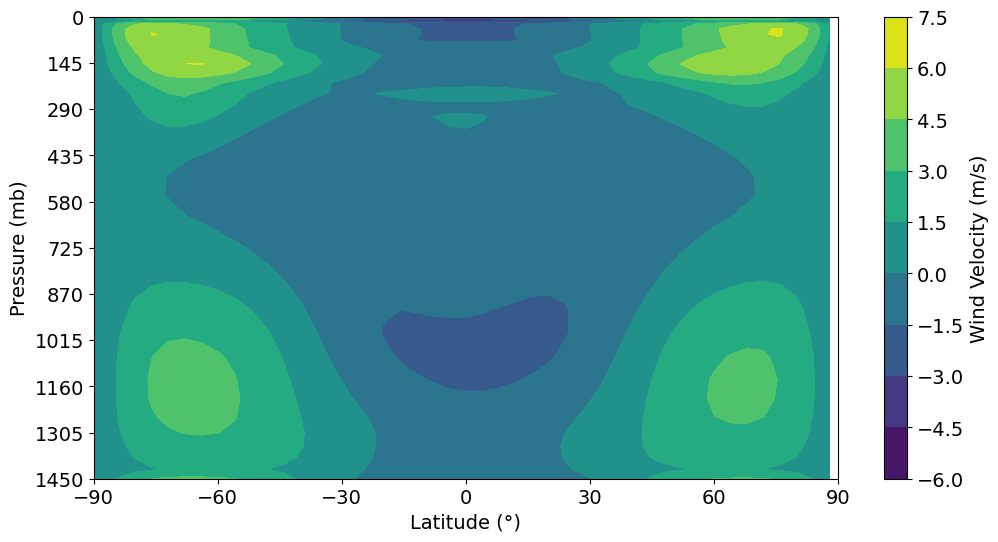

In [246]:
z = remNan(u)

savename = 'U'
graphContour(x,y,z,savename)

<Figure size 640x480 with 0 Axes>

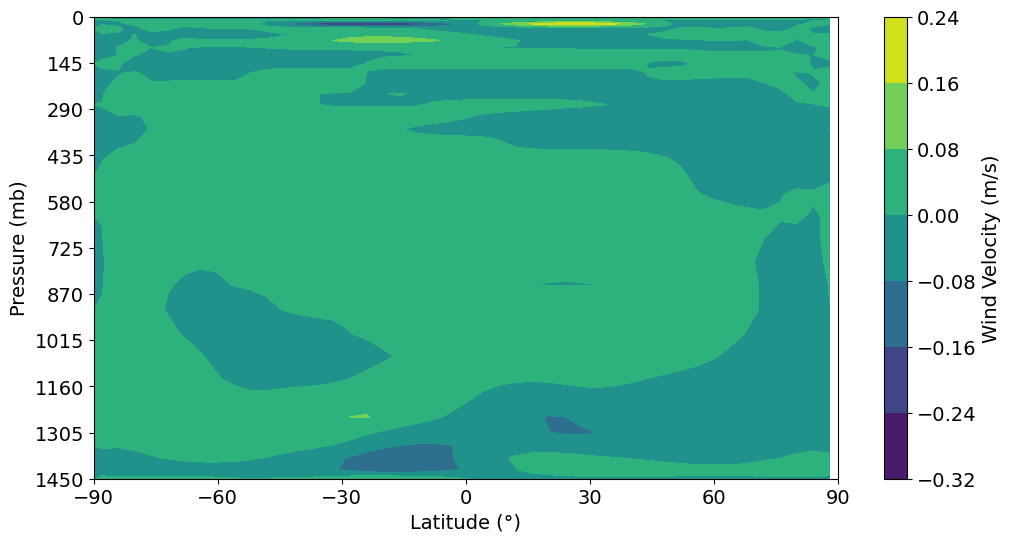

In [247]:
z = remNan(v)

savename = 'V'
graphContour(x,y,z,savename)

<Figure size 640x480 with 0 Axes>

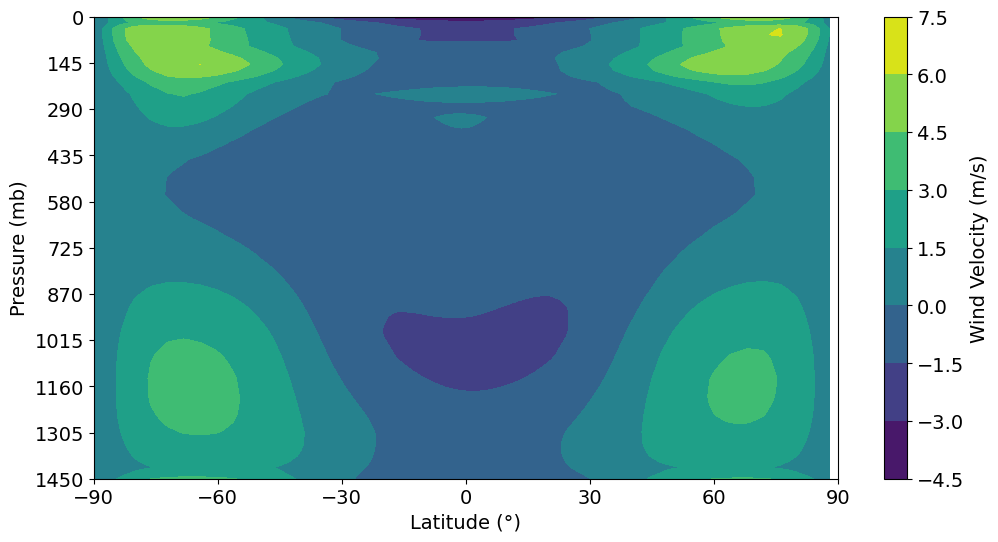

In [248]:
x_new, y_new, z_new = interpNans(x,y,u)

savename = 'U_interp'
graphContour(x_new,y_new,z_new,savename)

<Figure size 640x480 with 0 Axes>

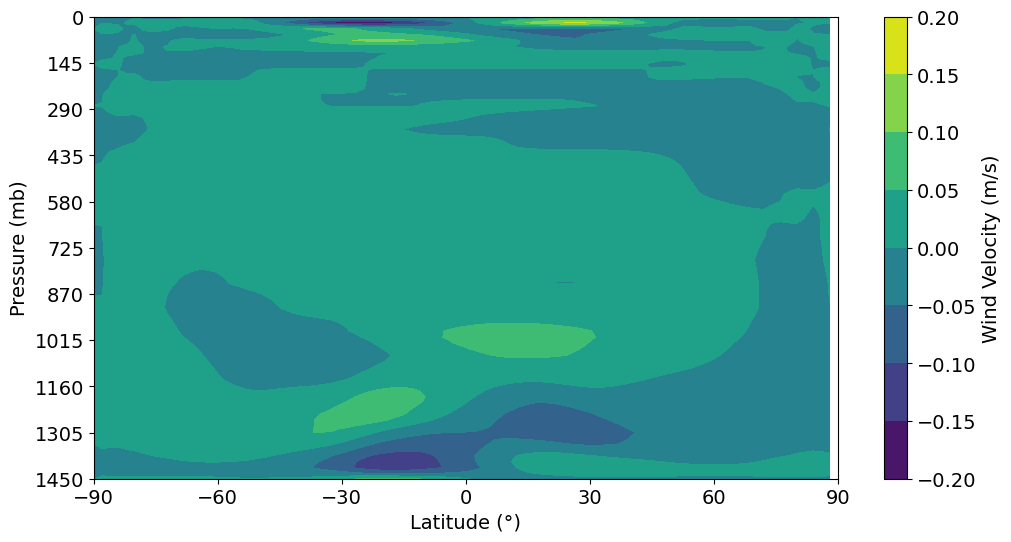

In [249]:
x_new, y_new, z_new = interpNans(x,y,v)

savename = 'V_interp'
graphContour(x_new,y_new,z_new,savename)